# Load flight data

Create `Flight` data structure for working with flight trajectories.

In [1]:
import pandas as pd
import numpy as np

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5

## Create Flight instance

### From Numpy Arrays

In [2]:
# waypoints
longitude = np.linspace(0, 50, 100)
latitude = np.linspace(0, 10, 100)
altitude = np.linspace(11000, 11500, 100)
time = pd.date_range("2022-03-01 00:00:00", "2022-03-01 02:00:00", periods=100)

fl = Flight(longitude=longitude, latitude=latitude, altitude=altitude, time=time, flight_id="id")
fl

Flight [4 keys x 100 length, 2 attributes]
	Keys: longitude, latitude, time, altitude
	Attributes:
	time                [2022-03-01 00:00:00, 2022-03-01 02:00:00]
	longitude           [0.0, 50.0]
	latitude            [0.0, 10.0]
	altitude            [11000.0, 11500.0]
	flight_id           id
	crs                 EPSG:4326

### From Pandas DataFrame

In [3]:
# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(0, 50, 100)
df["latitude"] = np.linspace(0, 10, 100)
df["altitude"] = 11000
df["time"] = pd.date_range("2022-03-01 00:00:00", "2022-03-01 02:00:00", periods=100)
fl = Flight(data=df, flight_id="ABC")
fl

Flight [4 keys x 100 length, 2 attributes]
	Keys: longitude, latitude, altitude, time
	Attributes:
	time                [2022-03-01 00:00:00, 2022-03-01 02:00:00]
	longitude           [0.0, 50.0]
	latitude            [0.0, 10.0]
	altitude            [11000.0, 11000.0]
	flight_id           ABC
	crs                 EPSG:4326

### Create Flight without Waypoints

In [4]:
# Example flight
attrs = dict(flight_id="1234", equip="A532")
fl = Flight.create_empty(attrs=attrs)
fl

Flight [4 keys x 0 length, 3 attributes]
	Keys: longitude, latitude, time, altitude
	Attributes:
	flight_id           1234
	equip               A532
	crs                 EPSG:4326

### Create from CSV file

In [5]:
# load flight
df = pd.read_csv("data/flight.csv")
fl = Flight(data=df, flight_id="csv")
fl

Flight [4 keys x 175 length, 2 attributes]
	Keys: longitude, latitude, altitude, time
	Attributes:
	time                [2022-03-01 00:50:00, 2022-03-01 03:47:00]
	longitude           [-97.026, -77.036]
	latitude            [32.931, 38.854]
	altitude            [190.5, 11582.4]
	flight_id           csv
	crs                 EPSG:4326

## Using the Flight instance

The `flight.data` attribute is a dictionary with `np.ndarray` values

In [6]:
# waypoints
longitude = np.linspace(0, 50, 10)
latitude = np.linspace(0, 10, 10)
altitude = np.linspace(11000, 11500, 10)
time = pd.date_range("2022-03-01 00:00:00", "2022-03-01 02:00:00", periods=10)
attrs = {"flight_id": "ABC123"}
fl = Flight(longitude=longitude, latitude=latitude, altitude=altitude, time=time, attrs=attrs)

In [7]:
fl.data.keys()

dict_keys(['longitude', 'latitude', 'time', 'altitude'])

`Flight` attributes are stored in a dictionary on the `attrs` attribute.
The `crs` attribute is always added by default, if not specified.

In [8]:
fl.attrs

{'flight_id': 'ABC123', 'crs': 'EPSG:4326'}

Data can be set / get from the `Flight` like a dictionary

In [9]:
# get
lat = fl["latitude"]

# set
lat[5] = 20
fl["latitude"] = lat

# get updated
fl["latitude"][5]

20.0

The `Flight` class contains the following convenience properties

In [10]:
# Pressure altitude, in hPa
fl.level

array([226.3170091 , 224.34300442, 222.3862176 , 220.44649846,
       218.52369813, 216.61766904, 214.7282649 , 212.85534072,
       210.99875274, 209.15835847])

In [11]:
# Altitude, in ft
fl.altitude_ft

array([36089.23884514, 36271.5077282 , 36453.77661126, 36636.04549431,
       36818.31437737, 37000.58326043, 37182.85214348, 37365.12102654,
       37547.38990959, 37729.65879265])

In [12]:
# Values that are constant along the flight path

# set constant value along flight waypoints
fl["constant"] = np.full(shape=fl.shape, fill_value=100)

fl.constants

{'constant': 100, 'flight_id': 'ABC123', 'crs': 'EPSG:4326'}

In [13]:
# Flight distance, in meters
fl.length

7818835.115366629

In [14]:
# Time start/end
print(fl.time_start)
print(fl.time_end)

2022-03-01 00:00:00
2022-03-01 02:00:00


In [15]:
# Flight duration, as a pandas Timedelta
fl.duration

Timedelta('0 days 02:00:00')

In [16]:
# Max time gap between waypoints, as a pandas Timedelta
fl.max_time_gap

Timedelta('0 days 00:13:20')

In [17]:
# Max distance gap between waypoints, in meters
fl.max_distance_gap

1831403.3492360476

## Intersect with Met data

In [18]:
# waypoints
longitude = np.linspace(0, 50, 50)
latitude = np.linspace(0, 10, 50)
altitude = np.linspace(11000, 11500, 50)
time = pd.date_range("2022-03-01 00:00:00", "2022-03-01 02:00:00", periods=50)
fl = Flight(longitude=longitude, latitude=latitude, altitude=altitude, time=time, flight_id="ABC")

In [19]:
# domain
time = ("2022-03-01 00:00:00", "2022-03-01 03:00:00")
variables = ["t", "q", "u", "v", "w", "ciwc", "z", "cc"]
pressure_levels = [300, 250, 200]

# get met data
era5 = ERA5(time=time, variables=variables, pressure_levels=pressure_levels)
met = era5.open_metdataset()

In [20]:
# interpolate to nearest grid member
fl.intersect_met(met["air_temperature"], method="nearest")

array([231.6297 , 231.5037 , 231.73001, 231.08833, 218.8252 , 218.8393 ,
       219.00676, 218.07823, 218.66353, 219.61859, 219.48346, 219.66501,
       219.8988 , 219.86067, 219.95186, 220.16989, 220.15166, 220.06793,
       219.71309, 219.5191 , 219.5647 , 219.54646, 219.39972, 219.1908 ,
       219.0192 , 219.02084, 219.36572, 219.42708, 219.39308, 219.49672,
       219.63931, 219.63351, 219.80347, 219.72304, 218.88406, 218.68758,
       219.5904 , 219.66667, 219.75786, 219.57713, 219.53734, 219.87642,
       219.74045, 219.47931, 219.345  , 219.28697, 219.14354, 219.04074,
       218.90147, 218.93463], dtype=float32)

In [21]:
# linear interpolation
fl.intersect_met(met["air_temperature"], method="linear")

array([225.77794, 225.39075, 225.21887, 224.88387, 225.13017, 224.75333,
       224.69849, 224.51218, 224.65642, 225.06851, 225.2779 , 225.23737,
       225.27412, 225.21637, 225.02275, 225.16205, 225.02489, 224.83875,
       224.50832, 224.36188, 224.2705 , 224.0278 , 223.71686, 223.553  ,
       223.37677, 223.35237, 223.489  , 223.45067, 223.46031, 223.51036,
       223.47456, 223.33977, 223.33707, 223.19572, 222.68132, 222.43277,
       222.99377, 222.90991, 222.94348, 222.70607, 222.66989, 222.84317,
       222.59155, 222.31973, 222.06894, 221.91066, 221.70157, 221.5247 ,
       221.33913, 221.26541], dtype=float32)

## Get Lengths

In [22]:
# total flight length in meters
fl.length

5642421.5973290345

In [23]:
# intersect flight with air temperature
fl["temp"] = fl.intersect_met(met["air_temperature"], method="nearest")

# get the length of the flight where ambient temperature is > 226 K
fl.length_met("temp", threshold=226)

462850.7958842697

## Plot and Resample

115715.16936791067

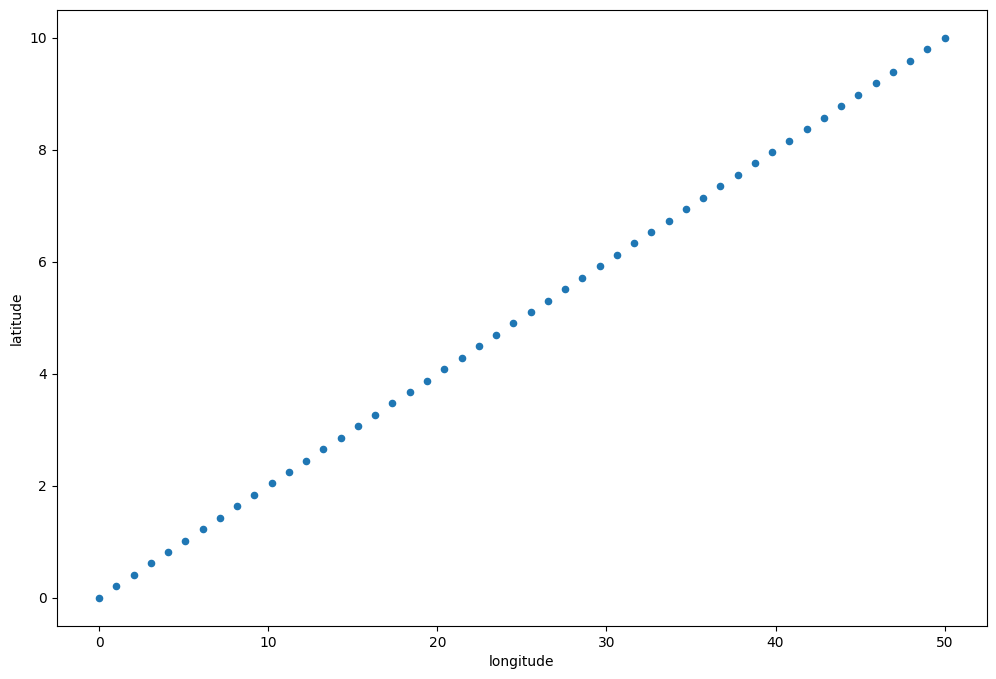

In [24]:
fl.dataframe.plot.scatter(x="longitude", y="latitude", figsize=(12, 8))
fl.max_distance_gap

472488.41576537804

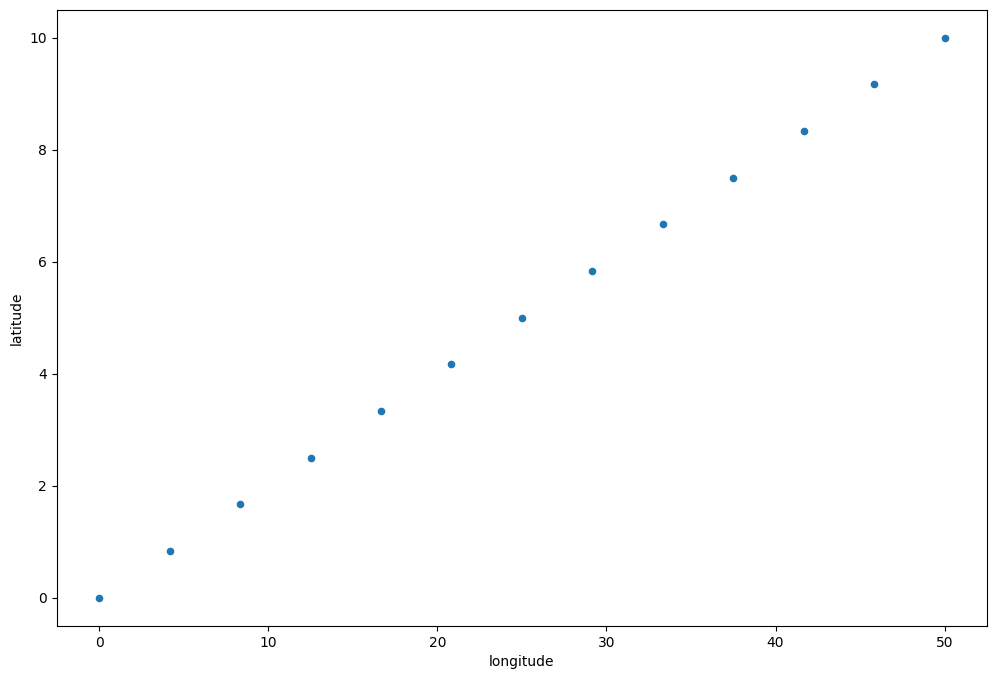

In [25]:
# resample with 10 minute waypoints
fl = fl.resample_and_fill("10min")

fl.dataframe.plot.scatter(x="longitude", y="latitude", figsize=(12, 8))
fl.max_distance_gap

7874.969421029368

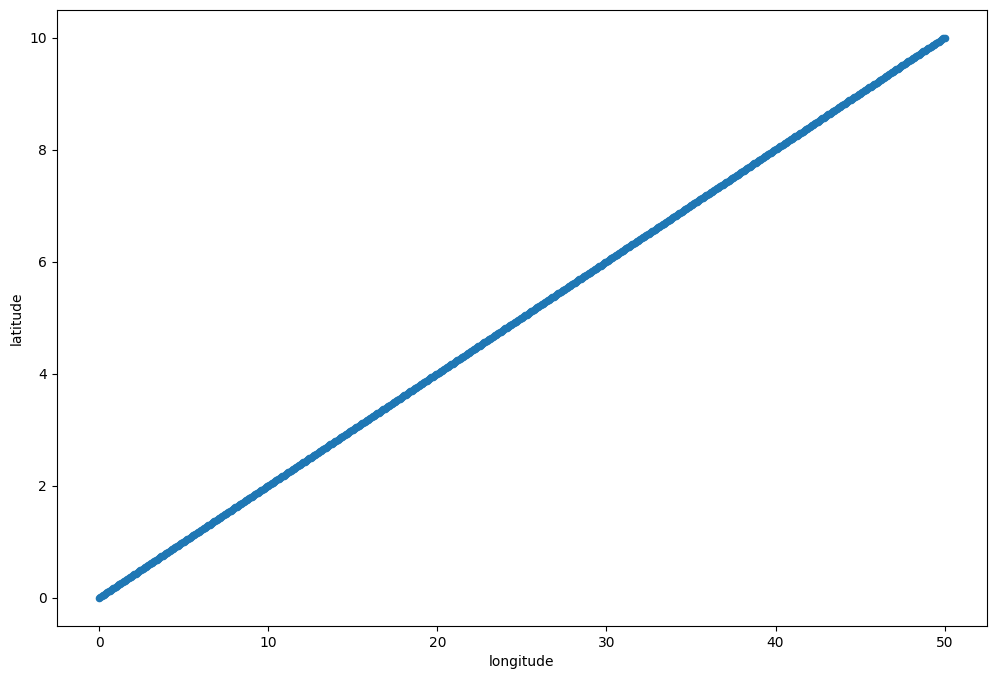

In [26]:
# resample with 10 second waypoints
fl = fl.resample_and_fill("10s")

fl.dataframe.plot.scatter(x="longitude", y="latitude", figsize=(12, 8))
fl.max_distance_gap

## Clean and smooth a noisy flight with gaps

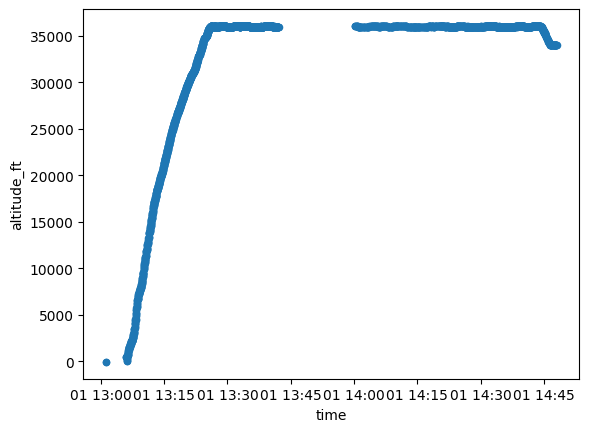

In [27]:
df = pd.read_csv("data/flight-noisy.csv")
df["time"] = df["time"].map(lambda t: np.datetime64(t))
f = Flight(df, drop_duplicated_times=True)
_ = f.dataframe.plot.scatter(x="time", y="altitude_ft")

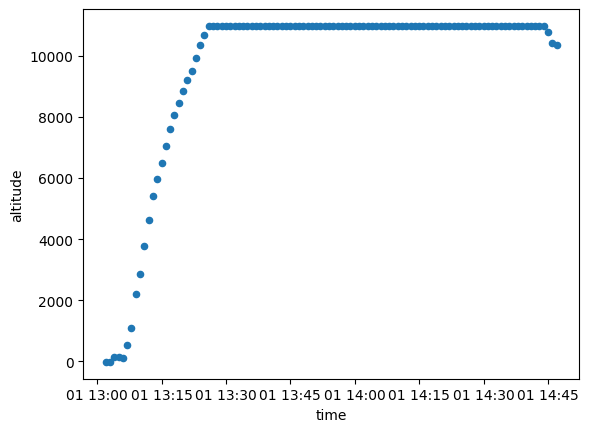

In [28]:
f = f.clean_and_resample(nominal_rocd=20)
_ = f.dataframe.plot.scatter(x="time", y="altitude")